## Chat myPDF : RAG with LangChain, Ollama, and FAISS Vector Store

In [ ]:
# pip install -U langchain-community faiss-cpu langchain-huggingface pymupdf tiktoken langchain-ollama python-dotenv

In [2]:
import os
import warnings
from dotenv import load_dotenv

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
warnings.filterwarnings("ignore")

load_dotenv()

True

### Document Loader

In [3]:
from langchain_community.document_loaders import PyMuPDFLoader

loader = PyMuPDFLoader("./data\AComprehensiveReview_deep_learning__Architectures,recentAdvances,andApplications.pdf")

docs = loader.load()

In [5]:
doc = docs[0]
print(doc.page_content)

Citation: Mienye, I.D.; Swart, T.G.
A Comprehensive Review of Deep
Learning: Architectures, Recent
Advances, and Applications.
Information 2024, 15, 755.
https://doi.org/10.3390/
info15120755
Academic Editor: Nicolas Guelfi
Received: 21 September 2024
Revised: 20 November 2024
Accepted: 21 November 2024
Published: 27 November 2024
Copyright: © 2024 by the authors.
Licensee MDPI, Basel, Switzerland.
This article is an open access article
distributed
under
the
terms
and
conditions of the Creative Commons
Attribution (CC BY) license (https://
creativecommons.org/licenses/by/
4.0/).
  
information
Article
A Comprehensive Review of Deep Learning: Architectures,
Recent Advances, and Applications
Ibomoiye Domor Mienye *,†
and Theo G. Swart †
Institute for Intelligent Systems, University of Johannesburg, Johannesburg 2006, South Africa; tgswart@uj.ac.za
* Correspondence: ibomoiyem@uj.ac.za
† These authors contributed equally to this work.
Abstract: Deep learning (DL) has become a core componen

In [6]:
import os

pdfs = []
for root, dirs, files in os.walk('data'):
    # print(root, dirs, files)
    for file in files:
        if file.endswith('.pdf'):
            pdfs.append(os.path.join(root, file))

In [7]:
docs = []
for pdf in pdfs:
    loader = PyMuPDFLoader(pdf)
    pages = loader.load()

    docs.extend(pages)

In [8]:
len(docs)

321

### Document Chunking

In [9]:
from langchain_text_splitters import RecursiveCharacterTextSplitter


text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=150)

chunks = text_splitter.split_documents(docs)

In [10]:
len(docs), len(chunks)

(321, 776)

In [11]:
len(docs[0].page_content), len(chunks[0].page_content)

(4234, 944)

In [12]:
import tiktoken

encoding = tiktoken.encoding_for_model("gpt-4o-mini")

len(encoding.encode(docs[0].page_content)), len(encoding.encode(chunks[0].page_content))

(876, 257)

### Document Vector Embedding

In [13]:
from langchain_ollama import OllamaEmbeddings

import faiss
from langchain_community.vectorstores import FAISS
from langchain_community.docstore.in_memory import InMemoryDocstore

In [15]:
embeddings = OllamaEmbeddings(model='nomic-embed-text', base_url="http://localhost:11434")

single_vector = embeddings.embed_query("this is some text data")


In [16]:
len(single_vector)

768

In [17]:
index = faiss.IndexFlatL2(len(single_vector))
index.ntotal, index.d

(0, 768)

In [18]:
vector_store = FAISS(
    embedding_function=embeddings,
    index=index,
    docstore=InMemoryDocstore(),
    index_to_docstore_id={}
)

In [19]:
len(chunks)

776

In [48]:
# help(vector_store)

In [20]:
ids = vector_store.add_documents(documents=chunks)

In [21]:
vector_store.index_to_docstore_id
len(ids)

776

In [54]:
# # store vector database
# db_name = "health_supplements"
# vector_store.save_local(db_name)

# # load vector database
# new_vector_store = FAISS.load_local(db_name, embeddings=embeddings, allow_dangerous_deserialization=True)
# len(new_vector_store.index_to_docstore_id)

321

### Retreival

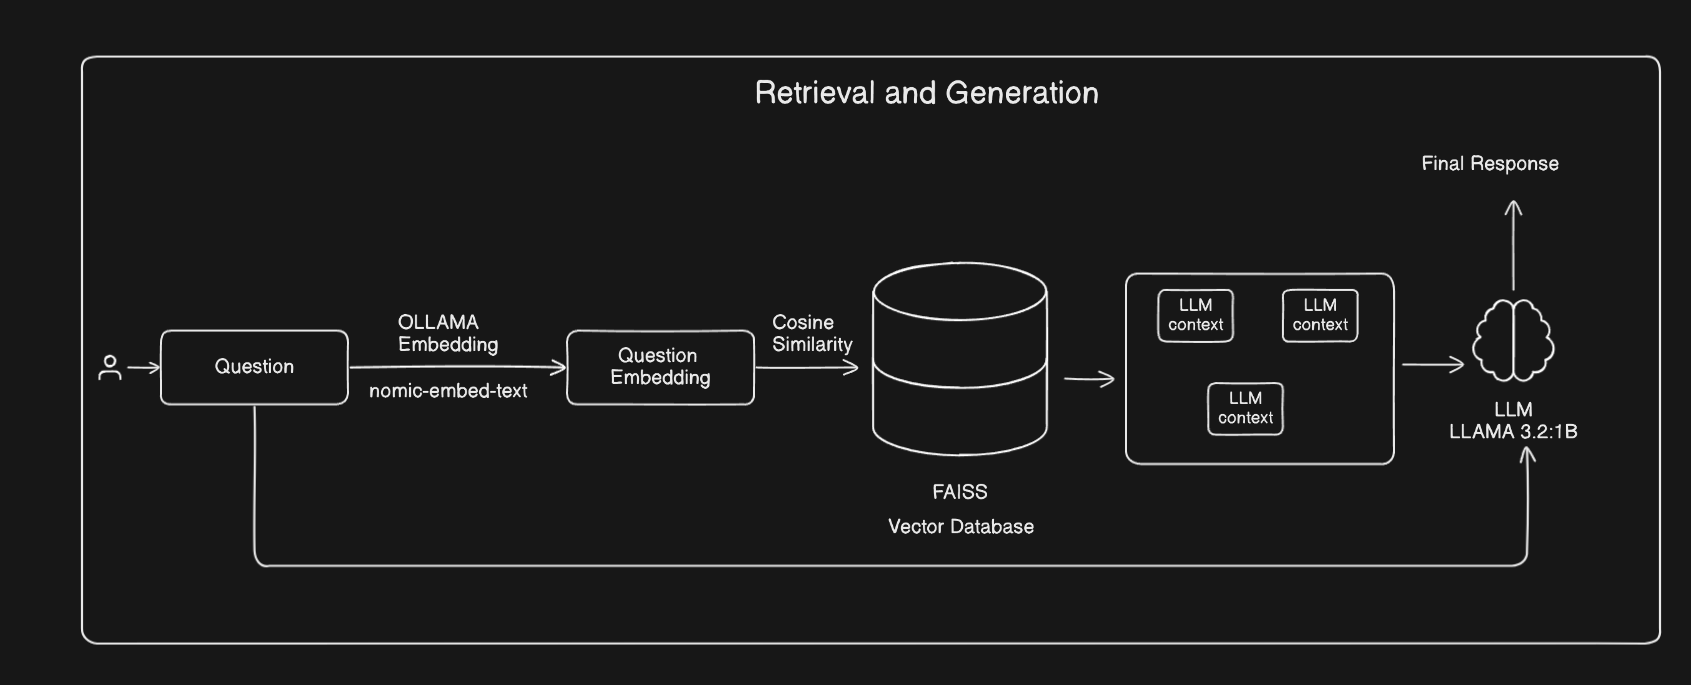

In [25]:
question = "what is the difference between federated learning and Reinforcement Learning?"
docs = vector_store.search(query=question, search_type='similarity')

for doc in docs:
    print(doc.page_content)
    print("\n\n")

from a wide range of sources without exposing individual data sets, federated learning
facilitates more personalized and sensitive applications. This technique not only enhances
privacy and data security but also harnesses the power of distributed data sources to create
models that are both diverse in their learning and comprehensive in their application.
5.4. Deep Reinforcement Learning
Deep reinforcement learning (DRL) represents an advanced training technique that
combines reinforcement learning principles with deep neural networks, allowing models to
learn optimal behaviors through interaction with an environment [95]. Unlike traditional
supervised or unsupervised learning methods, DRL relies on a feedback mechanism where
the model, or agent, explores different actions to maximize a reward signal over time.
The core of DRL’s training methodology is the iterative learning process guided by the
Bellman equation, which helps the agent estimate the optimal policy by updating its



93.

In [26]:
retriever = vector_store.as_retriever(search_type="mmr", search_kwargs = {'k': 3, 
                                                                          'fetch_k': 100,
                                                                          'lambda_mult': 1})

In [27]:
docs = retriever.invoke(question)

# for doc in docs:
#     print(doc.page_content)
#     print("\n\n")


In [66]:


question = "what is used to reduce weight?"
# question = "what are side effects of supplements?"
# question = "what are the benefits of supplements?"
# question = "what are the benefits of BCAA supplements?"
docs = retriever.invoke(question)


### RAG with LLAMA 3.2 on OLLAMA

In [28]:
from langchain import hub
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_core.prompts import ChatPromptTemplate

from langchain_ollama import ChatOllama

In [29]:
model = ChatOllama(model="llama3.2", base_url="http://localhost:11434")

model.invoke("hi")

AIMessage(content='How can I help you today?', additional_kwargs={}, response_metadata={'model': 'llama3.2', 'created_at': '2025-01-05T15:08:21.3566906Z', 'done': True, 'done_reason': 'stop', 'total_duration': 5007742100, 'load_duration': 4562611100, 'prompt_eval_count': 26, 'prompt_eval_duration': 354000000, 'eval_count': 8, 'eval_duration': 89000000, 'message': Message(role='assistant', content='', images=None, tool_calls=None)}, id='run-429d2b80-19fa-4dcd-b781-49c9a78ee927-0', usage_metadata={'input_tokens': 26, 'output_tokens': 8, 'total_tokens': 34})

In [30]:
prompt = hub.pull("rlm/rag-prompt")

In [31]:
prompt = """
    You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question.
    If you don't know the answer, just say that you don't know.
    Answer in bullet points. Make sure your answer is relevant to the question and it is answered from the context only.
    Question: {question} 
    Context: {context} 
    Answer:
"""

prompt = ChatPromptTemplate.from_template(prompt)

In [32]:
def format_docs(docs):
    return "\n\n".join([doc.page_content for doc in docs])

# print(format_docs(docs))

In [33]:
rag_chain = (
    {"context": retriever|format_docs, "question": RunnablePassthrough()}
    | prompt
    | model
    | StrOutputParser()
)

In [34]:
# question = "what is used to gain muscle mass?"
# question = "what is used to reduce weight?"
# question = "what are side effects of supplements?"
# question = "what are the benefits of supplements?"
# question = "what are the benefits of BCAA supplements?"

question = "what is the difference between federated learning and Reinforcement Learning?"

output = rag_chain.invoke(question)
print(output)


Here are the key differences between Federated Learning and Reinforcement Learning:

• **Purpose**: Federated Learning aims to enhance privacy and data security by minimizing data leakage in environments where sensitive information is present. In contrast, Reinforcement Learning focuses on training models to optimize behaviors through interaction with an environment.

• **Data sharing**: Federated Learning allows for model training across multiple devices or servers without exchanging individual data sets, whereas Reinforcement Learning relies on a feedback mechanism that explores different actions to maximize a reward signal.

• **Training methodology**: Federated Learning involves iterative rounds of computation where a central server disseminates current model parameters to participating devices. In contrast, Reinforcement Learning uses an iterative learning process guided by the Bellman equation to estimate optimal policies.

• **Model development**: Federated Learning enables orga

In [35]:
question = "what is the difference between hierarchical clustering and k-means clustering?"

output = rag_chain.invoke(question)
print(output)

Here are the differences between hierarchical clustering and k-means clustering in bullet points:

• **Definition of Close**: Hierarchical clustering doesn't specify a fixed distance metric to determine when things are close together, whereas K-means clustering uses a predefined distance metric (e.g. Euclidean).
• **Grouping**: Hierarchical clustering organizes data into a hierarchy by merging or splitting groups, while K-means clustering groups data by finding centroids of fixed clusters.
• **Visualization**: Hierarchical clustering can be visualized as a tree-like structure, while K-means clustering doesn't have a built-in visualization method (although it can be represented graphically).
• **Interpretation**: Both methods provide interpretation challenges, but hierarchical clustering requires more subjective decision-making when choosing the "cut" point to determine the number of clusters.
• **Purpose**: Hierarchical clustering is often used for exploratory data analysis and identif

In [36]:
question = "what are the different loss functions used in deep learning models?"

output = rag_chain.invoke(question)
print(output)

Here are the different loss functions mentioned in the context:

• Mean Squared Error (MSE): used primarily in regression tasks, calculates the average squared difference between actual and predicted values.
• Cross-entropy loss: widely used in classification problems, heavily penalizes confident but incorrect predictions.


In [ ]:
question = "what are the different loss functions used in deep learning models?"

output = rag_chain.invoke(question)
print(output)